<center>

# Supervised Learning Classification Project
## Hypertension risk

</center>

***Ideas***

- **<span style='color:red'> Don't forget to put dataset justification !! </span>**

**Notes**

- I systematically used cross-validation to evaluate the model's performance because the dataset is quite small so I am not confident that it is representative of the overall population.

https://www.kaggle.com/datasets/khan1803115/hypertension-risk-model-main/

### Hypertension Risk Dataset Objectives
- Establish a classification model as good as possible for hypertension risk prediction and assess its performance metrics
- Establish critical features correlated to hypertension risk

In [17]:
## Text formatting utility and helper functions for matplotlib

ansi = {
    'bold': '\033[1m',
    'underline': '\033[4m',
    'end': '\033[0m',
    'red': '\033[91m',
    'green': '\033[92m',
    'yellow': '\033[93m',
    'blue': '\033[94m',
    'magenta': '\033[95m',
    'cyan': '\033[96m',
}

def bold(text):
    return ansi['bold'] + str(text) + ansi['end']

def bold_red(text):
    return ansi['bold'] + ansi['red'] + str(text) + ansi['end']

def bold_blue(text):
    return ansi['bold'] + ansi['blue'] + str(text) + ansi['end']

def add_percentage(ax, total, color='white', y_offset=60):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2 - y_offset
        ax.annotate(percentage, (x, y), ha='center', va='bottom', color=color, fontsize=12, fontweight='bold')

def set_xlabels_horizontal(ax):
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

## Dataset Overview

In [18]:
import pandas as pd
from matplotlib import pyplot as plt

hypertension_data = pd.read_csv('Hypertension-risk-model-main.csv', sep=',')

initial_rows_count = hypertension_data.shape[0]
print(initial_rows_count, "rows in the dataset")
hypertension_data.head()

4240 rows in the dataset


,male,age,currentSmoker,cigsPerDay,BPMeds,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Risk
0,1,39,0,0.0,0.0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


#### Assumptions
- heartRate feature indicates the heart rate in **resting** state (no prior effort)
- glucose level is _fasting_ blood glucose concentration and the unit is mg/dL
- total cholesterol unit's is mg/dL

## Data Preparation and Analysis

#### Skewness analysis of categorical variables

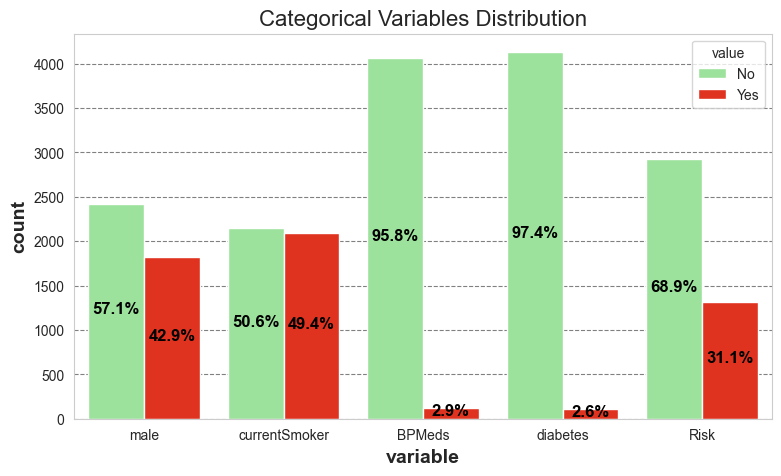

In [19]:
import pandas as pd
import seaborn as sns

categorical_columns = ['male', 'currentSmoker', 'BPMeds', 'diabetes', 'Risk']

df_categorical = hypertension_data.loc[:, categorical_columns].replace({0: 'No', 1: 'Yes'})

sns.set_style(style="whitegrid", rc={"grid.linestyle": '--', "grid.color": "0.5"})

plt.figure(figsize=(9, 5))
ax = sns.countplot(data=pd.melt(df_categorical), x='variable', hue='value', palette=['lightgreen', (1,0.1,0)], hue_order=['No', 'Yes'])

add_percentage(ax, len(hypertension_data), color='black')
ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')
ax.set_title('Categorical Variables Distribution', fontsize=16);

- We can see that the dataset is **skewed towards healthy subjects** (about 2 healthy subjects for 1 high risk subject).
- There is an **extreme bias** towards subjects not taking **BP medication** as well as those **not having diabetes**.

#### Missing values cleanup (brute-force approach)

In [20]:
import numpy as np

## TODO: draw a bar plot for the distribution of missing values in the dataset (see comment below) or a nullity matrix

# Check for all columns to be numeric
assert all(np.issubdtype(hypertension_data[col].dtype, np.number) for col in hypertension_data.columns), "Not all rows are numeric"

# Check for missing values in data (NaN or None)
missing_values_any = hypertension_data.isnull().any(axis=1)
missing_values_df = pd.DataFrame(hypertension_data.isnull().sum(), columns=['Count']).T
if missing_values_any.sum() != 0:
    print(f"{bold_red(missing_values_any.sum())} rows ({missing_values_df.sum(axis=1).values[0]} total NA values) with missing values in the data out of {hypertension_data.shape[0]}")
    display(missing_values_df)
    # missing_values_df.plot(title='Missing values distribution', y='Count', kind='bar');
else:
    print("No missing values in the data")

489 rows (540 total NA values) with missing values in the data out of 4240


,male,age,currentSmoker,cigsPerDay,BPMeds,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Risk
Count,0,0,0,29,53,0,50,0,0,19,1,388,0


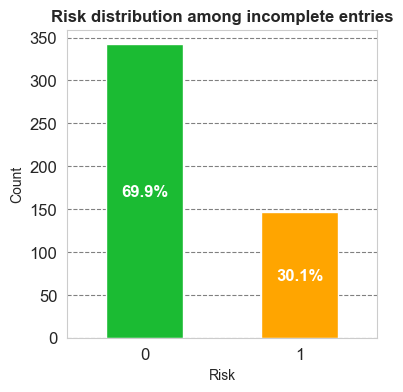

In [21]:
plt.ylabel('Count')
ax = hypertension_data[missing_values_any].groupby('Risk').size().plot(title='Risk distribution among incomplete entries',
                                                                  kind='bar', figsize=(4, 4), color=['#1BBB33','#FFA500'], fontsize=12);
ax.title.set_fontweight('bold')
ax.grid(axis='x', visible=False)
set_xlabels_horizontal(ax)
add_percentage(ax, missing_values_any.sum(), y_offset=10)

The bias in regards to the target is almost preserved among incomplete entries => removing them won't impact the initial bias by a lot.

In [22]:
# Missing values removal

hypertension_data.dropna(inplace=True)
print(bold_red(f"Removed {initial_rows_count - hypertension_data.shape[0]} entries"), "out of", initial_rows_count, "with brute-force approach (dropping rows with missing values)")
print(bold_blue(hypertension_data.shape[0]), "entries left in the dataset")

Removed 489 entries out of 4240 with brute-force approach (dropping rows with missing values)
3751 entries left in the dataset


In [23]:
# Check for duplicate entries
duplicates = hypertension_data.duplicated().sum()
if duplicates != 0:
    print(f"{bold_red(duplicates)} duplicate entries found in the data")
else:
    print("No duplicate entries found in the data")

No duplicate entries found in the data


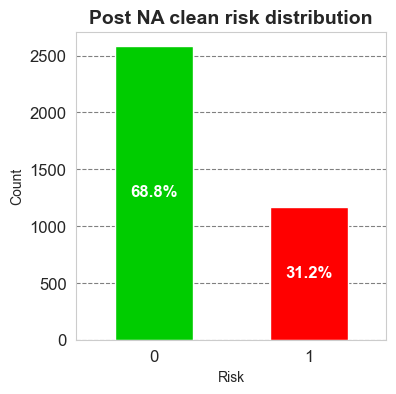

In [24]:
plt.ylabel('Count')
size_df = hypertension_data.groupby('Risk').size()
ax = size_df.plot(title='Post NA clean risk distribution', x='Risk', kind='bar',
                                              color=['#00CC00','#FF0000'], figsize=(4, 4), fontsize=12);

ax.title.set_fontweight('bold')
ax.title.set_fontsize(14)

# Add percentage labels on each bar
add_percentage(ax, size_df.sum())
ax.grid(axis='x', visible=False)
set_xlabels_horizontal(ax)

#### Outliers exploration (univariate analysis)

Number of outliers detected using Z-Score method: 205
Number of outliers detected using IQR method: 469
199 outliers detected by Z-Score method are also detected by IQR method


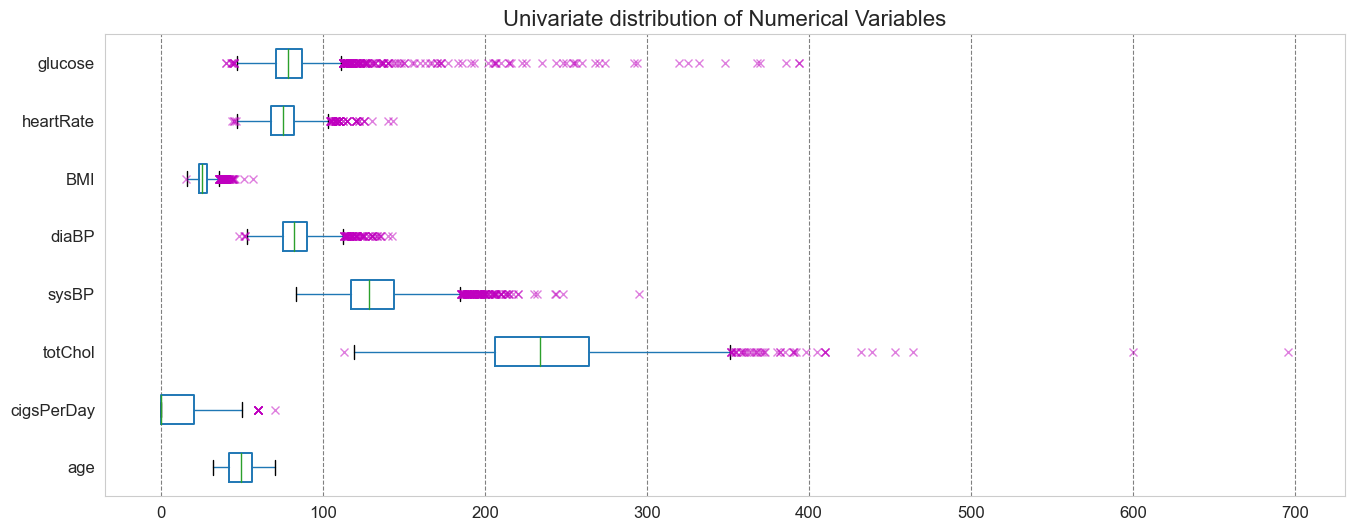

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

# Horizontal boxplots
numerical_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
plot_return = hypertension_data[numerical_columns].boxplot(figsize=(16, 6), sym='xm', whis=1.5, flierprops=dict(alpha=0.5), return_type='both', vert=False, fontsize=12)
fliers, ax = plot_return[1]['fliers'], plot_return[0]
ax.set_title('Univariate distribution of Numerical Variables', fontsize=16)
plt.rcParams['xtick.minor.visible'] = True
ax.grid(which='minor', axis='x', linestyle=':', linewidth=1, visible=True)
plt.Axes.tick_params(ax, axis='x', which='minor', bottom=True)
ax.grid(which='major', axis='y', visible=False)

for line in plot_return[1]['boxes']:
    line.set_linewidth(1.4)

# Z-Score outlier detection
z_scores = zscore(hypertension_data[numerical_columns])
STD_DEV_THRESHOLD = 3 # 3 is 99.7% of the data, 2 is 95.4%
outliers_zscore = (np.abs(z_scores) > STD_DEV_THRESHOLD).any(axis=1)
outliers_zscore_count = outliers_zscore.sum()
print(f"Number of outliers detected using Z-Score method: {outliers_zscore_count}")

# Interquartile Range (IQR) outlier detection
whiskers = 1.5
Q1 = hypertension_data[numerical_columns].quantile(0.25)
Q3 = hypertension_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((hypertension_data[numerical_columns] < (Q1 - whiskers * IQR)) |
                (hypertension_data[numerical_columns] > (Q3 + whiskers * IQR))).any(axis=1)
outliers_iqr_count = outliers_iqr.sum()
print(f"Number of outliers detected using IQR method: {outliers_iqr_count}")

# IQR and Z-score outlier detection results comparison
zscore_in_IQR = hypertension_data[outliers_zscore].isin(hypertension_data[outliers_iqr]).any(axis=1).sum()
print(f"{zscore_in_IQR} outliers detected by Z-Score method are also detected by IQR method")

In [26]:
for i, flier in enumerate(fliers):
    feature_outliers = flier.get_ydata().shape[0]
    print(f"{numerical_columns[i]}: {feature_outliers}")

age: 0
cigsPerDay: 11
totChol: 42
sysBP: 110
diaBP: 69
BMI: 86
heartRate: 81
glucose: 181


**Statistical comparison of the 2 methods**

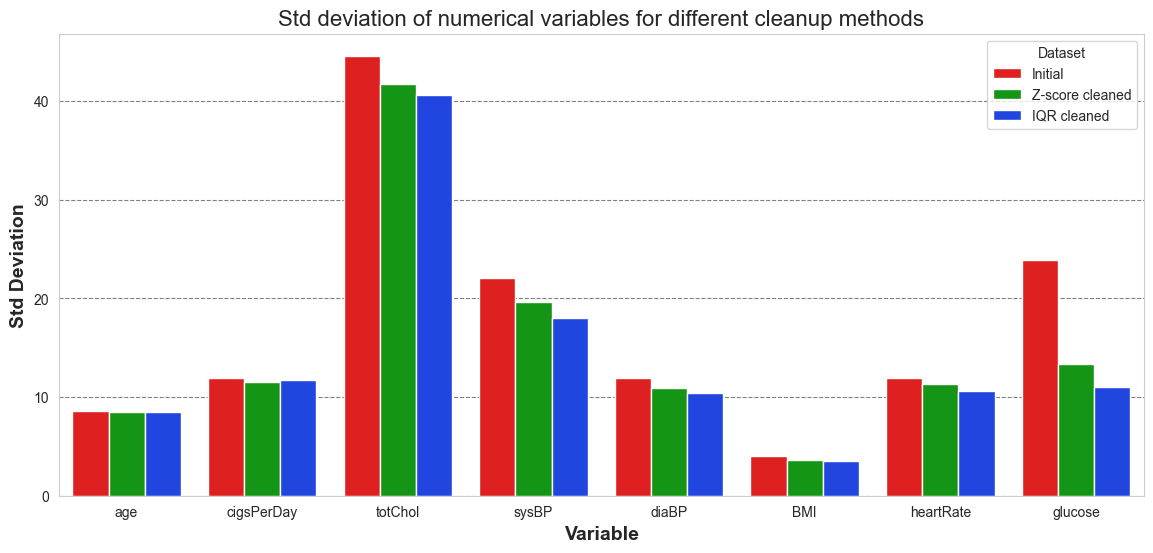

In [28]:
import pandas as pd

iqr_cleaned_std = hypertension_data[~outliers_iqr].std()

z_score_cleaned_std = hypertension_data[~outliers_zscore].std()

# Calculate the std of the dataset before cleanup
initial_std = hypertension_data.std()

# Create a dataframe with the std values
std_comparison_df = pd.DataFrame({'Initial': initial_std,'Z-score cleaned': z_score_cleaned_std, 'IQR cleaned': iqr_cleaned_std}).T.loc[:,numerical_columns]

# std_comparison_df.style.apply(lambda r:['background: yellow' if r.name == 'std(IQR cleaned dataset)' else '']*len(numerical_columns), axis=1)
# std_comparison_df.style.set_table_styles([dict(selector='th', props=[('background-color', '#000066'), ('color','white')])])

std_comparison_df = std_comparison_df.reset_index().rename(columns={'index': 'Dataset'})
std_comparison_df = std_comparison_df.melt(id_vars='Dataset', var_name='Variable', value_name='Std Deviation')

plt.figure(figsize=(14, 6));
ax = sns.barplot(data=std_comparison_df, x='Variable', y='Std Deviation', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF']);
plt.title('Std deviation of numerical variables for different cleanup methods', fontsize=16);
ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')

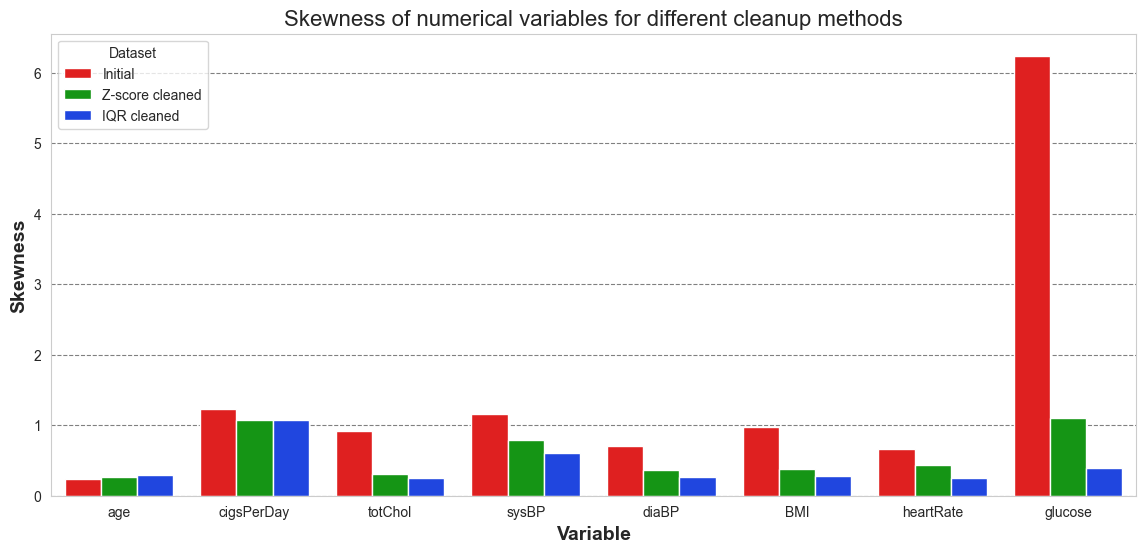

In [29]:
z_score_cleaned_skew = hypertension_data[~outliers_zscore].skew()
iqr_cleaned_skew = hypertension_data[~outliers_iqr].skew()

skewness_df = pd.DataFrame({'Initial': hypertension_data.skew(),'Z-score cleaned': z_score_cleaned_skew, 'IQR cleaned': iqr_cleaned_skew}).T.loc[:,numerical_columns]
skewness_df = skewness_df.reset_index().rename(columns={'index': 'Dataset'})
skewness_df = skewness_df.melt(id_vars='Dataset', var_name='Variable', value_name='Skewness')

plt.figure(figsize=(14, 6));
ax = sns.barplot(data=skewness_df, x='Variable', y='Skewness', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF'])
plt.title('Skewness of numerical variables for different cleanup methods', fontsize=16)

ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')

['Initial' 'glucose' 59.432634538400784]


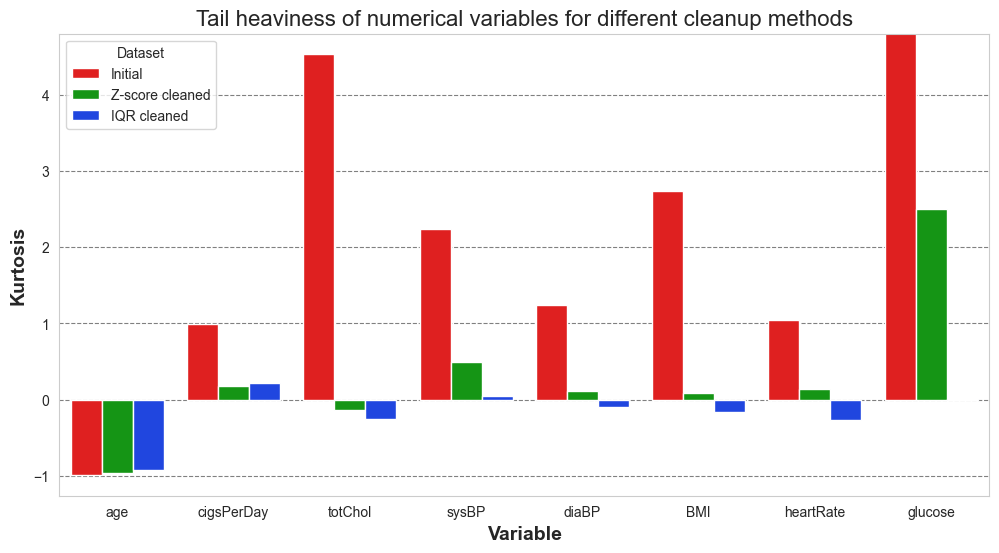

In [30]:
z_score_cleaned_kurtosis = hypertension_data[~outliers_zscore].kurtosis()
iqr_cleaned_kurtosis = hypertension_data[~outliers_iqr].kurtosis()

kurtosis_df = pd.DataFrame({'Initial': hypertension_data.kurtosis(),'Z-score cleaned': z_score_cleaned_kurtosis, 'IQR cleaned': iqr_cleaned_kurtosis}).T.loc[:,numerical_columns]
kurtosis_df = kurtosis_df.reset_index().rename(columns={'index': 'Dataset'})
kurtosis_df = kurtosis_df.melt(id_vars='Dataset', var_name='Variable', value_name='Kurtosis')

plt.figure(figsize=(12, 6));
ax = sns.barplot(data=kurtosis_df, x='Variable', y='Kurtosis', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF'])
plt.title('Tail heaviness of numerical variables for different cleanup methods', fontsize=16)

ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')
ax.set_ylim(-1.26, 4.8)
print(kurtosis_df.loc[21].values)

plt.show()

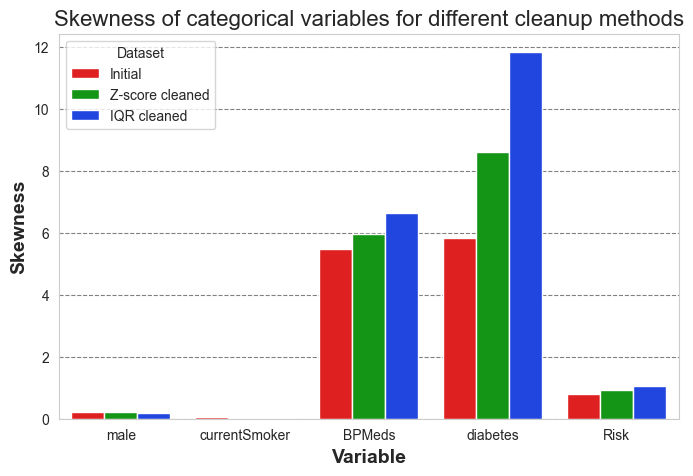

In [31]:
z_score_cleaned_skew = hypertension_data[~outliers_zscore].skew()
iqr_cleaned_skew = hypertension_data[~outliers_iqr].skew()

skewness_df = pd.DataFrame({'Initial': hypertension_data.skew(),'Z-score cleaned': z_score_cleaned_skew, 'IQR cleaned': iqr_cleaned_skew}).T.loc[:,categorical_columns]
skewness_df = skewness_df.reset_index().rename(columns={'index': 'Dataset'})
skewness_df = skewness_df.melt(id_vars='Dataset', var_name='Variable', value_name='Skewness')

plt.figure(figsize=(8, 5));
ax = sns.barplot(data=skewness_df, x='Variable', y='Skewness', hue='Dataset', palette=['#FF0000', '#00AA00', '#0033FF'])
plt.title('Skewness of categorical variables for different cleanup methods', fontsize=16)

ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontweight('bold')

We choose the **IQR method** (will remove more data points than Z-score).

**Justification for choosing IQR outliers removal over Z-score method**:

*Skewness*: IQR method decreases much more biases across the numerical variables, as well as their standard deviation.\
However, when considering categorical variables, it is slightly worse in regards to the target (we can ignore that for now), and really worse for diabetes and BPMeds.

*Kurtosis*: IQR produces higher and opposite kurtosis than Z-score method for BMI, heart rate and total cholesterol. It's better for glucose, age and sysBP. Overall, it is better than Z-score considering numerical variables.

Additionally, IQR outliers set mostly contains outliers detected by Z-score method.

**Further outliers investigation and handling**:
- A 4th method could be removing outliers based on realistic value ranges (according to health research institutions).
- We could use use a hybrid method IQR/Z-score, using IQR on certain variables and Z-score for others.
- We could use a more refined IQR method by adjusting per-variable whiskers to decrease the numbers of outliers removed with IQR

In [32]:
# Remove outliers using IQR method
hypertension_data_cleaned = hypertension_data[~outliers_iqr]

# Verify the number of rows after removing outliers
print(bold_red(f"Removed {outliers_iqr_count} outliers."))
print(bold_blue(hypertension_data_cleaned.shape[0]), "entries left in the dataset")

Removed 469 outliers.
3282 entries left in the dataset


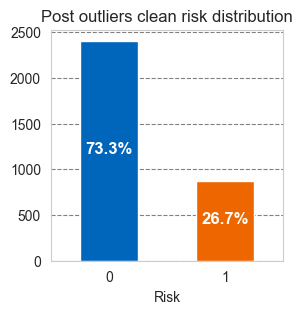

In [33]:
size_cleaned_df = hypertension_data_cleaned.groupby('Risk').size()

ax = size_cleaned_df.plot(title='Post outliers clean risk distribution', kind='bar',
                                              color=['#0066BB','#EE6600'], figsize=(3, 3));

# Add percentage labels on each bar
add_percentage(ax, size_cleaned_df.sum())

set_xlabels_horizontal(ax)
ax.grid(axis='x', visible=False)

#### Bivariate analysis (post outliers cleanup)

In [34]:
# Checking for weird values in the dataset

print("Diastolic is higher than systolic pressure in", hypertension_data_cleaned[hypertension_data_cleaned['diaBP'] > hypertension_data_cleaned['sysBP']].shape[0], "cases.")

Diastolic is higher than systolic pressure in 0 cases.


```py
import seaborn as sns

plt.figure(dpi=100)
g = sns.pairplot(hypertension_data_cleaned, hue="Risk", palette="husl", corner=True, hue_order=[1, 0], plot_kws={'alpha': 0.65},
                 diag_kws={'common_norm': False, 'fill': True, 'alpha': 0.5}, markers=['o', 's'], height=2.5, aspect=1.25)
                #  diag_kind='hist', diag_kws={'bins': 10})

# Add ticks with numbers to axes on every subplot
for ax in g.axes.flat:
  if ax is not None:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())

plt.subplots_adjust(wspace=0.3, hspace=0.3);
```

Looking at the diagonal, the univariate plots of diastolic and systolic BP as well as he 2D plot sysBP vs diaBP show a clear correlation between BP and hypertension.

Older people seem to have a higher chance of having hypertension according to the univariate distribution of age.

People with higher cholesterol and higher BMI might also have a slightly higher chance.

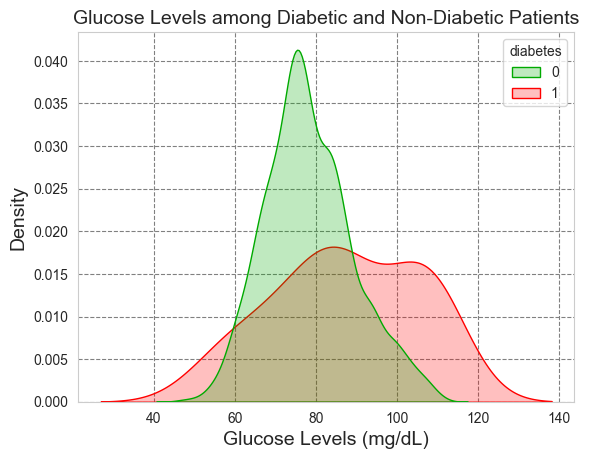

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.kdeplot(data=hypertension_data_cleaned, x='glucose', hue='diabetes', fill=True, common_norm=False, palette=['#00AA00','#FF0000'])

plt.xlabel('Glucose Levels (mg/dL)')
plt.ylabel('Density')
plt.title('Glucose Levels among Diabetic and Non-Diabetic Patients', fontsize=14)

ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)

plt.show()

Diabetic patients mostly don't have their glucose levels above 125 mg/dL, which is surprising if we consider WHO's statement that they should be diagnosed with diabetes. An explanaton could be that they have insulin intakes, which doesn't make them outliers.\
Non-diabetic patients mostly have healthy glucose levels.

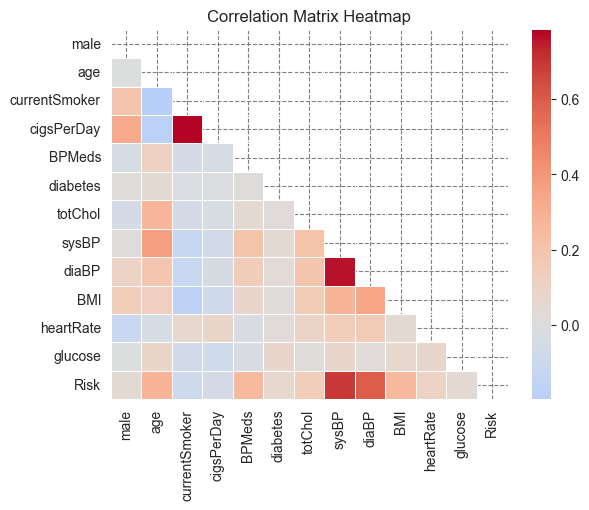

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = hypertension_data_cleaned.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, center=0, linewidths=0.5, fmt=".1f")

plt.title('Correlation Matrix Heatmap')
plt.show()

**Glucose levels**:\
Healthy glucose levels are 70-100 mg/dL. 100 to 125 mg/dL is moderately elevated. Beyond 125 mg/dL, diabetes is diagnosed. Below 70 is hypoglycemia.\
(*WHO*)

**Total cholesterol levels**:\
Healthy total cholesterol levels is below 200 mg/dL. 200 to 240 mg/dL is moderately elevated. Beyond that is high.\
(*Journal of the American College of Cardiology (JACC)*)

**Blood pressure levels**:\
Low sys,dia < 90/60 (hypotension)\
Healthy sys,dia between 90/60 and 120/80\
High sys,dia > 135/85\
(*NHS*)\
Highest < 190/100


**Using IQR method for outliers detection when considering realistic values**

- Glucose levels: decrease lower bound to include outliers, increase upper bound to include outliers.
- Total cholesterol : bounds OK
- Diastolic & systolic : increase upper bound to include outliers for diastolic, OK for systolic

## Model Selection and Training

**Dataset split and scaling**

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = hypertension_data_cleaned.drop('Risk', axis=1), hypertension_data_cleaned['Risk']

# Split the data into training and testing sets
# MUST split the data before scaling to avoid data leakage from test set to training set
TEST_SPLIT_PORTION = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SPLIT_PORTION, random_state=42)

def scale_data(X_train, X_test=None):
    std_scaler = StandardScaler()
    X_train_scaled = std_scaler.fit_transform(X_train)
    if X_test is not None:
        X_test_scaled = std_scaler.transform(X_test) # Apply the same transformation to the test set
        return X_train_scaled, X_test_scaled
    else:
        return X_train_scaled

X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
print("Training set size:", X_train_scaled.shape, "Testing set size:", X_test_scaled.shape)

X_train2 = X_train.drop("currentSmoker", axis=1)
X_train3 = X_train2.drop("BPMeds", axis=1)
X_train4 = X_train3.drop("diabetes", axis=1)

del X, y

Training set size: (2625, 12) Testing set size: (657, 12)


The following code is utility code for model performance assessment.

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

def fit_unscaled_and_cross_validate(X_train, y_train, model, print_results=True, cv=None):
    X_train_scaled = StandardScaler().fit_transform(X_train)
    
    model.fit(X_train_scaled, y_train)
    scores_list = []

    for scoring in ['recall', 'precision']:
        # Warning: there is a problem of data leakage here, as the scaling fit was done on the whole dataset
        # Ideally, the scaling fit should be done inside the cross-validation loop, on the folds used for training only.
        # Then, the scaling transform should be applied to the test fold.
        if cv is None:
            cv = RepeatedStratifiedKFold(n_repeats=3, random_state=42)
        score = cross_val_score(model, X_train_scaled, y_train, cv=cv, n_jobs=-1, scoring=scoring).mean()
        scores_list.append(score)
        if print_results:
            print(f"Cross-Validation {scoring.capitalize()}:", round(score*100, 1), "%")
    return scores_list


def plot_performance_vs_features_dropped(feature_importances, X_train, y_train, model, cv=None):
    num_features_to_drop = range(0, len(feature_importances))
    precision_scores = []
    recall_scores = []

    for num_drop_features in num_features_to_drop:
        dropped_features = feature_importances[:num_drop_features]
        X_train_selected = X_train.drop(dropped_features, axis=1)

        recall, precision = fit_unscaled_and_cross_validate(X_train_selected, y_train, model, print_results=False, cv=cv)

        precision_scores.append(precision)
        recall_scores.append(recall)

    plt.plot(num_features_to_drop, precision_scores, label='Precision', marker='o')
    plt.plot(num_features_to_drop, recall_scores, label='Recall', marker='o')
    plt.xlabel('Number of Features Dropped')
    plt.ylabel('Score')
    plt.title(f'Performance of {type(model).__name__} based on incremental dropping of features')
    plt.legend()
    plt.show()

MEAN_CONF_MAT_SPLITS = 3
def avg_confusion_mat_cv(X_train, y_train, model, splits=MEAN_CONF_MAT_SPLITS):
    cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=splits, random_state=42)
    confusion_matrices = []
    std_scaler = StandardScaler()
    for train_index, test_index in cv.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        X_train_cv_scaled = std_scaler.fit_transform(X_train_cv)
        X_test_cv_scaled = std_scaler.transform(X_test_cv)
        
        model.fit(X_train_cv_scaled, y_train_cv)
        y_pred = model.predict(X_test_cv_scaled)
        confusion_matrices.append(confusion_matrix(y_test_cv, y_pred))
    return np.mean(confusion_matrices, axis=0)


def plot_confusion_matrix(confusion_matrix, title, size=(4,4)):
    display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Healthy", "Risky"])
    conf_plot = display.plot(colorbar=False)
    conf_plot.ax_.set_title(title)
    conf_plot.ax_.grid(False)
    conf_plot.figure_.set_size_inches(*size)

**Performance metrics choice**

Picked metrics are **Recall and Precision**, recall being the priority. We don't use ROC AUC because we care more about false negatives than false positives (ROC AUC cares equally about them) and our classes are imbalanced. However, we need to keep in mind that precision and recall scores are for a fixed threshold and do not consider all possible thresholds.

[ROC vs Precision-recall curves on imbalanced dataset (StackEx)](https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)

### **Random Forest Classifier**

We start with **RF classifier**. We will try to get the highest results with it.

Then, we can try to do feature reduction and optimization. (like remove highly correlated features)

Then we will try other classifiers (Logistic and SVM) with ensemble learning by means of the hard voting classifier.

We might then go back to data prep to see if we can improve the maximum results we got by tweaking the params on the models.

**Default params for Random Forest**:

```py
n_estimators=100, 
criterion='gini', 
max_depth=None, 
min_samples_split=2, 
min_samples_leaf=1, 
min_weight_fraction_leaf=0.0, 
max_features='auto', 
max_leaf_nodes=None, 
min_impurity_decrease=0.0, 
min_impurity_split=None, 
bootstrap=True, 
oob_score=False, 
warm_start=False, 
class_weight=None, 
ccp_alpha=0.0, 
max_samples=None
```

Cross-Validation Recall: 85.1 %
Cross-Validation Precision: 81.0 %

Cross Validation set size (in single fold): 875


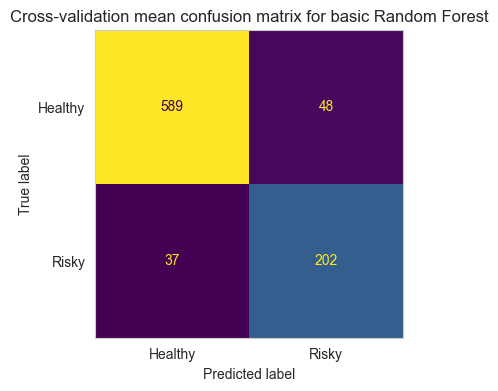

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_basic = RandomForestClassifier(random_state=42, n_jobs=-1)
fit_unscaled_and_cross_validate(X_train, y_train, rf_basic);

print()

# Build the confusion matrix from cross validation scores
confusion_mat = avg_confusion_mat_cv(X_train, y_train, rf_basic)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for basic Random Forest')

#### **Hyperparameters optimization**

Grid Search too computationally demanding for this model, use of *Randomized Search* is more appropriate.\
We can use both by starting with *Randomized Search* to find a good set of parameters and refining with *Grid Search* to find the best combination among this set.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_dist = {
    'n_estimators': [500, 1000],
    'max_features': [0.7],
    # 'max_depth': [None, 10, 25, 50],
    'min_samples_split': [2, 4, 8],
    'max_samples': [0.7, None],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 16],
    'criterion': ['entropy'],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.1, 0.2]
}

rf = RandomForestClassifier()

# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=200, cv=5, n_jobs=-1, verbose=2, scoring='recall')
random_search = GridSearchCV(estimator=rf, param_grid=param_dist, cv=3, n_jobs=-1, verbose=2, scoring='recall')

random_search.fit(X_train_scaled, y_train)

print(random_search.best_params_)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 0.7, 'max_leaf_nodes': 16, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


**Results of hyperparams search**:

Found with RSearchCv using recall as scoring:

2. {'n_estimators': 500, 'min_samples_split': 5, 'max_samples': 0.9, 'max_leaf_nodes': 16, 'max_features': 0.7}
3. {'n_estimators': 500, 'min_samples_split': 10, 'max_samples': 0.9, 'max_leaf_nodes': 16, 'max_features': 0.7, 'criterion': 'entropy'} (to find this, I set up the params of the search to include the previous params and added new values to params and other params as well)
4. **Best** :{'criterion': 'entropy', 'max_features': 0.7, 'max_leaf_nodes': 16, 'n_estimators': 500, 'class_weight':'balanced'}

<center>

| **Model**         | Initial |   2  |   3  |                    Best                    |
|-------------------|:-------:|:----:|:----:|:------------------------------------------:|
| **Recall (%)**    | 85.1    | 89.5 | 90.7 | <span style="color:red">91.9</span>    |
| **Precision (%)** | 81      | 73.6 | 78.7 | <span style="color:red">78.1</span>    |

```python
Best params: {'criterion': 'entropy', 'max_features': 0.7, 'max_leaf_nodes': 16, 'n_estimators': 500, 'class_weight':'balanced'}
```
</center>

Cross-Validation Recall: 91.9 %
Cross-Validation Precision: 78.1 %

Cross Validation set size (in single fold): 875


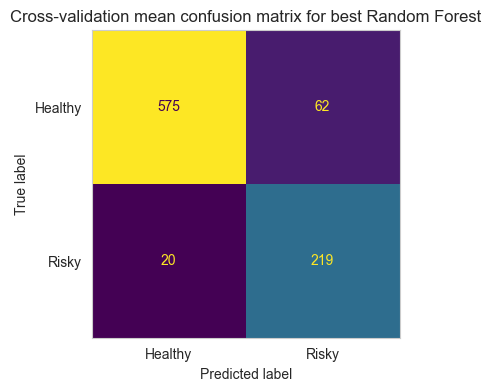

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_optimal_params = {'criterion': 'entropy', 'max_features': 0.7, 'max_leaf_nodes': 16, 'n_estimators': 500, 'class_weight':'balanced'}
# rf_optimal_params = {'n_estimators': 500, 'min_samples_split': 10, 'max_samples': 0.65, 'max_leaf_nodes': 16, 'max_features': 0.9, 'criterion': 'log_loss', 'class_weight': 'balanced'}
rf_best_clf = RandomForestClassifier(**rf_optimal_params, random_state=42, n_jobs=-1)

fit_unscaled_and_cross_validate(X_train, y_train, rf_best_clf);

print()

# Build the confusion matrix from cross validation scores
confusion_mat = avg_confusion_mat_cv(X_train, y_train, rf_best_clf)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for best Random Forest')

We will now try to see if Random Forest classifier could benefit from **more training data**, making it worth to go back to the data prep step (to try imputation instead of brute force for instance) for this specific classifier. We will use the learning curve to do so.

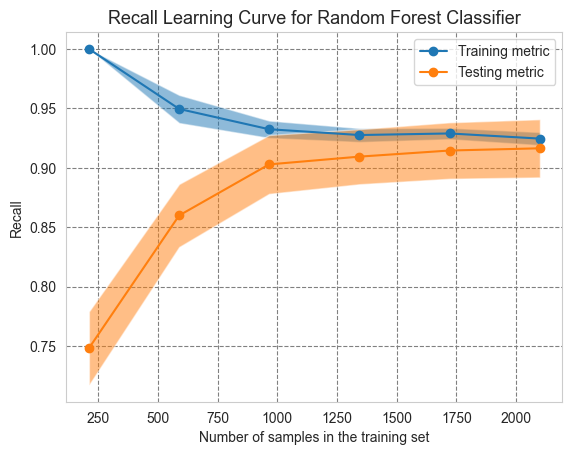

In [235]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(rf_best_clf, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1, 6), cv=RepeatedStratifiedKFold(n_repeats=3), scoring='recall',
                                    score_name='Recall', score_type='both', line_kw={"marker": "o"}, n_jobs=-1, random_state=42);

plt.title('Recall Learning Curve for Random Forest Classifier', fontsize=13);

It seems that acquiring more training data will not be useful as we reached a plateau on the validation recall score.

#### **Feature selection**

Let's now try to select features according to data analysis and feature importances

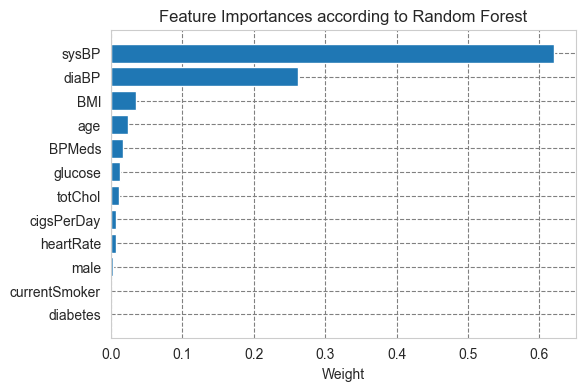

In [44]:
# for feature, importance in feature_importances:
#     print(f"{feature}: {importance:.3f}")

def plot_rf_feature_importances(importances, feature_names):
    feature_importances = list(zip(feature_names, importances))
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=False)

    plt.figure(figsize=(6, 4))
    plt.barh(range(len(feature_importances)), [importance for _, importance in feature_importances], align='center')
    plt.yticks(range(len(feature_importances)), [feature for feature, _ in feature_importances])
    plt.xlabel('Weight')
    plt.title('Feature Importances according to Random Forest')
    plt.show()

plot_rf_feature_importances(rf_best_clf.feature_importances_, hypertension_data_cleaned.columns[:-1])

feature_importances_rf_best = sorted(list(zip(X_train.columns, rf_best_clf.feature_importances_)), key=lambda x: x[1], reverse=False)
feature_importances_names_rf = [feature for feature, _ in feature_importances_rf_best]

In [265]:
X_train_rf_merge_BP = X_train2.copy()

# Create a new feature 'sysDiaBP'
X_train_rf_merge_BP['sysDiaBP'] = X_train2['sysBP'] + X_train2['diaBP']

X_train_rf_merge_BP.drop(['sysBP', 'diaBP'], axis=1, inplace=True)

print(bold("Training best RF model with new 'sysDiaBP' feature"))
fit_unscaled_and_cross_validate(X_train_rf_merge_BP, y_train, rf_best_clf);

Training best RF model with new 'sysDiaBP' feature
Cross-Validation Recall: 87.9 %
Cross-Validation Precision: 75.2 %


**Features dropping**

We can try to drop features one by one, from least important to most, following the ranking given by the best model so far, and look at the evolution of performance across each drop.

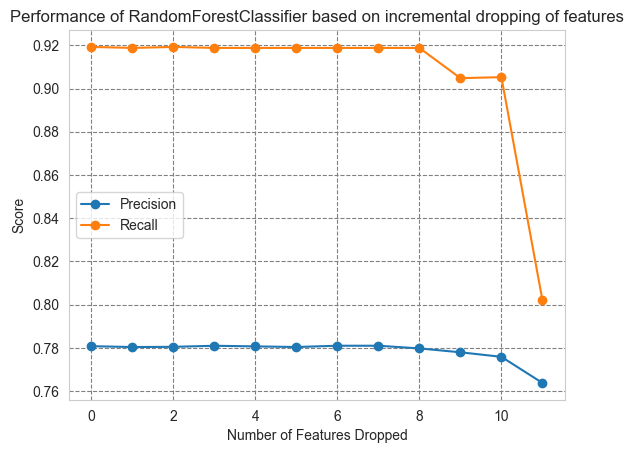

In [374]:
plot_performance_vs_features_dropped(feature_importances_names_rf, X_train, y_train, rf_best_clf)

The previous method has an issue which is that it does not check if the feature importance ranking has changed after a drop. This issue can be mitigated with *Recursive Feature Elimination*.

We can first try to see the 4 best features (dropping 8 features in total), and then run RFECV to have an automatic detection of the ideal number of features to keep and what they are.

In [80]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=rf_best_clf, n_features_to_select=4, step=1)
rfe.fit(X_train_scaled, y_train)

print(bold(f"Selected features (4): {list(X_train.columns[rfe.support_])}"))

rfe = RFE(estimator=rf_best_clf, n_features_to_select=3, step=1)
rfe.fit(X_train_scaled, y_train)

print(bold(f"Selected features (3): {list(X_train.columns[rfe.support_])}"))

Selected features (4): ['BPMeds', 'sysBP', 'diaBP', 'BMI']
Selected features (3): ['sysBP', 'diaBP', 'BMI']


In [304]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=rf_best_clf, step=1, cv=5, scoring='recall', n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

print("Optimal number of features:", rfecv.n_features_)
print(bold(f"Selected features: {list(X_train.columns[rfecv.support_])}"))

Optimal number of features: 7
Selected features: ['age', 'BPMeds', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate']


Training best RF model without ['diabetes', 'currentSmoker', 'male', 'heartRate', 'cigsPerDay'] features (7 features left)
Cross-Validation Recall: 91.8 %
Cross-Validation Precision: 78.0 %


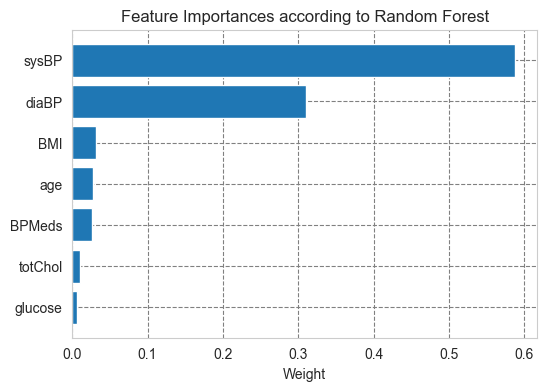

In [45]:
dropped_features = feature_importances_names_rf[:5]
X_train_rf = X_train.drop(dropped_features, axis=1)
print(bold(f"Training best RF model without {dropped_features} features ({X_train_rf.shape[1]} features left)"))
fit_unscaled_and_cross_validate(X_train_rf, y_train, rf_best_clf)
plot_rf_feature_importances(rf_best_clf.feature_importances_, X_train_rf.columns)

<center>

<span style="color:red">**Conclusion of feature selection**</span>

No significant improvement was made with feature selection through feature importances. The best validation performance remains **(91.8% R, 78.8% P)**\
The retained features are **heart rate, total cholesterol, systolic & diastolic BP, age, BMI and BP medication**.
</center>

### **Support Vector Machine Classifier**

**Default Support Vector Machine Params**

- C: 1
- kernel: rbf
- degree: 3
- gamma: scale
- probability: False
- class_weight: None
- max_iter: -1
- decision_function_shape: ovr
- tol: 1e-3
- shrinking: True
- break_ties: False

```py

C=1.0,
break_ties=False,
gamma='scale',
class_weight=None,
coef0=0.0,
decision_function_shape='ovr',
degree=3, gamma='scale',
kernel='rbf',
max_iter=-1,
probability=False,
shrinking=True,
tol=0.001
```

Cross-Validation Recall: 75.7 %
Cross-Validation Precision: 82.7 %

Cross Validation set size (in single fold): 875


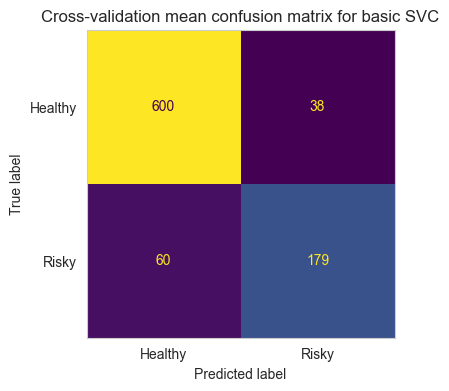

In [307]:
from sklearn.svm import SVC

svc_basic = SVC(random_state=42)
fit_unscaled_and_cross_validate(X_train_scaled, y_train, svc_basic);

print()

# Build the confusion matrix from cross validation scores
confusion_mat = avg_confusion_mat_cv(X_train, y_train, svc_basic)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for basic SVC')

#### **Hyperparameter optimization**

Again, this model is quite resource demanding, especially with higher values of parameter **γ**, so *Randomized Search* is used.

In [142]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 'scale', 'auto', 1, 0.01],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'probability': [False, True],
    'class_weight': ['balanced'],
    # 'max_iter': [1000],
    'shrinking': [True, False],
    # 'tol': [1e-3],
    'decision_function_shape': ['ovo', 'ovr'],
    # 'break_ties': [True, False],
}

svc = SVC(random_state=42, cache_size=1800)

random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2, scoring='recall')

X_train2_scaled = scale_data(X_train2)

random_search.fit(X_train2_scaled, y_train)

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'shrinking': True, 'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'decision_function_shape': 'ovo', 'class_weight': 'balanced', 'C': 1}


**Results of hyperparams search**:

2. {'shrinking': False, 'probability': True, 'kernel': 'poly', 'gamma': 1, 'degree': 2, 'class_weight': 'balanced'}
3. **Best** {'class_weight': 'balanced', 'C': 1}

<center>

| **Model**         | Initial |   2  |   -  |                    Best                    |
|-------------------|:-------:|:----:|:----:|:------------------------------------------:|
| **Recall (%)**    | 75.7    | 86 | - | <span style="color:red">88.7</span>    |
| **Precision (%)** | 82.7     | 75.6 | - | <span style="color:red">72.7</span>    |

```python
Best params: {'class_weight': 'balanced', 'C': 1}
```
</center>

In [59]:
from sklearn.svm import SVC

svc_optimal_params = {'class_weight': 'balanced', 'C': 1}
svc_best_clf = SVC(**svc_optimal_params, random_state=42)

fit_unscaled_and_cross_validate(X_train, y_train, svc_best_clf);

Cross-Validation Recall: 88.7 %
Cross-Validation Precision: 72.7 %


#### **Feature selection**

**Permutation Importance**

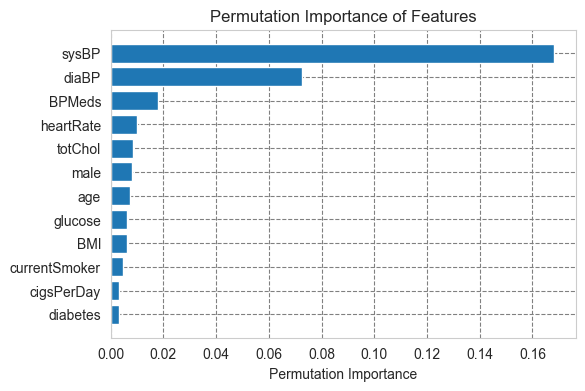

In [60]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(svc_best_clf, X_train_scaled, y_train, n_repeats=10, n_jobs=-1, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
feature_importance_svc = list(X_train.columns[sorted_idx])

plt.figure(figsize=(6, 4))
plt.barh(feature_importance_svc, perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

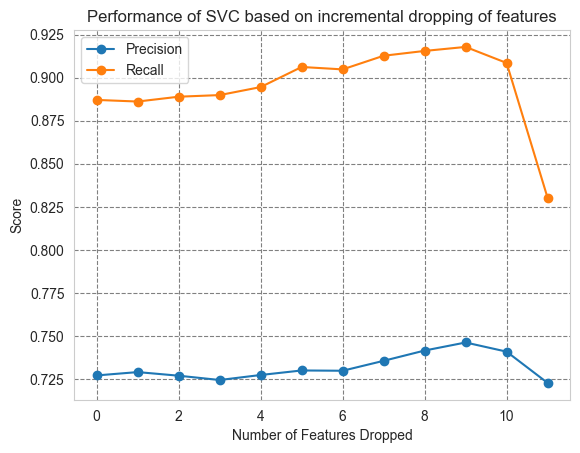

In [373]:
import matplotlib.pyplot as plt

plot_performance_vs_features_dropped(feature_importance_svc, X_train, y_train, svc_best_clf)

Training best RF model without ['diabetes', 'cigsPerDay', 'currentSmoker', 'BMI', 'glucose', 'age', 'male', 'totChol', 'heartRate'] features (3 features left)
Cross-Validation Recall: 91.8 %
Cross-Validation Precision: 74.6 %

Cross Validation set size (in single fold): 875


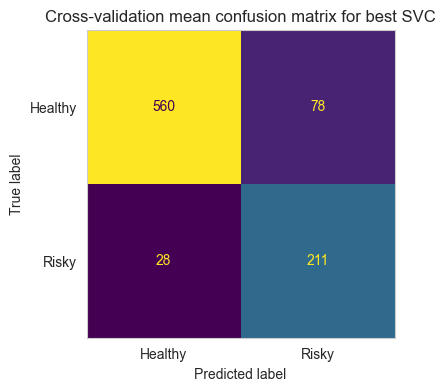

In [61]:
dropped_features = feature_importance_svc[:9]
X_train_svc = X_train.drop(dropped_features, axis=1)
print(bold(f"Training best RF model without {dropped_features} features ({X_train_svc.shape[1]} features left)"))
fit_unscaled_and_cross_validate(X_train_svc, y_train, svc_best_clf);

print()

# Build the confusion matrix from cross validation scores
confusion_mat = avg_confusion_mat_cv(X_train, y_train, svc_best_clf)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for best SVC')

***Remark***: The features dropping method used here has the same issue as mentioned for the Random Forest, but RFE cannot be used with this classifier. Ideally, we would need to compute permutation importance after each feature drop to select the least important feature to drop next.

<center>

<span style="color:red">**Conclusion of feature selection**</span>

Slightly better performance was achieved thanks to feature selection using permutation importance. The retained features are **systolic, diastolic BP and BP medication**.

| **Model**         | Initial |   2  |   3  |                    Best                    |
|-------------------|:-------:|:----:|:----:|:------------------------------------------:|
| **Recall (%)**    | 75.7    | 86 | 89.5 | <span style="color:red">91.8</span>    |
| **Precision (%)** | 82.7     | 75.6 | 73.6 | <span style="color:red">74.6</span>    |
</center>





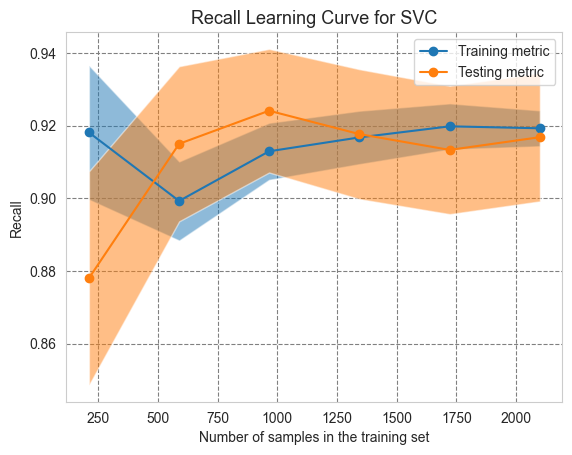

In [310]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(svc_best_clf, scale_data(X_train_svc), y_train, train_sizes=np.linspace(0.1, 1, 6), cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42), scoring='recall',
                                    score_name='Recall', score_type='both', line_kw={"marker": "o"}, n_jobs=-1, random_state=42);

plt.title('Recall Learning Curve for SVC', fontsize=13);

For this classifier, it's harder to tell whether more data could be of use, but it's possible.

### **Logistic Classifier**

**Default hyperparams**

```py
penalty='l2',
dual=False,
tol=0.0001,
C=1.0,
fit_intercept=True,
intercept_scaling=1,
class_weight=None,
random_state=None,
solver='lbfgs',
max_iter=100,
multi_class='auto',
warm_start=False,
l1_ratio=None

```

Cross-Validation Recall: 75.0 %
Cross-Validation Precision: 84.5 %

Cross Validation set size (in single fold): 875


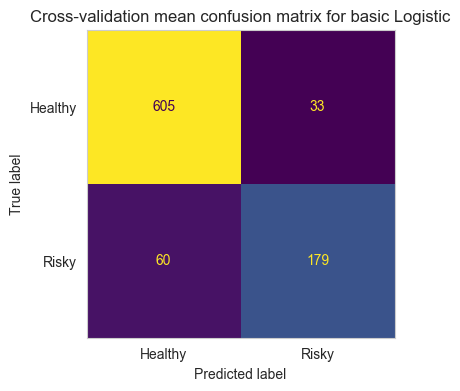

In [312]:
from sklearn.linear_model import LogisticRegression

lr_basic = LogisticRegression(random_state=42, max_iter=10000)
fit_unscaled_and_cross_validate(X_train_scaled, y_train, lr_basic);

print()

# Build the confusion matrix from cross validation scores
confusion_mat = avg_confusion_mat_cv(X_train, y_train, lr_basic)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for basic Logistic')

#### **Hyperparameters optimization**

In [193]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_dist = {
    'penalty': ['l2'], #'elasticnet', 'l1', None],
    'C': [0.1, 1, 10, 100],
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg'], # not with l1: 'sag', 'newton-cg', 'newton-cholesky' | multinomial not with newton-cholesky and liblinear
    'max_iter': [100, 1000, 10000],
    'class_weight': ['balanced'],
    'multi_class': ['multinomial'],
    # 'l1_ratio': [0.1, 0.5, 0.9],
    'fit_intercept': [True, False],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
}

# Initialize a Random Forest classifier
lr = LogisticRegression(random_state=42, n_jobs=-1, verbose=2)

# Initialize a RandomizedSearchCV object
random_search = GridSearchCV(estimator=lr, param_grid=param_dist, cv=5, n_jobs=-1, verbose=1, scoring='recall')
# random_search = RandomizedSearchCV(estimator=lr, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2, scoring='recall')

# Fit the RandomizedSearchCV object to your data
random_search.fit(X_train_scaled, y_train)

# Print the best parameters
print(random_search.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
convergence after 5 epochs took 0 seconds
{'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 100, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga', 'tol': 0.1}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [62]:
lr_optimal_params = {'penalty': None, 'multi_class': 'multinomial', 'class_weight': 'balanced'}
lr_best_clf = LogisticRegression(**lr_optimal_params, random_state=42)

fit_unscaled_and_cross_validate(X_train, y_train, lr_best_clf);

Cross-Validation Recall: 87.9 %
Cross-Validation Precision: 72.9 %


**Results for Logistic Classifier**

- **Best** {'penalty': None, 'multi_class': 'multinomial', 'class_weight': 'balanced'}\
Same:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.01}
- 93.8 recall, 62.3 precision: {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': False, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.01}
- 94.9 recall, 58.9 precision: {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1}
- 95.7 recall, 56.9 precision: {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': False, 'solver': 'newton-cholesky', 'tol': 0.1}

<center>

| **Model**         | Initial |   2  |   -  |                    Best                    |
|-------------------|:-------:|:----:|:----:|:------------------------------------------:|
| **Recall (%)**    | 75    | 93.8  | - | <span style="color:red">87.9</span>    |
| **Precision (%)** | 84.5     | 62.3  | - | <span style="color:red">72.9</span>    |

```python
Best params: {'penalty': None, 'multi_class': 'multinomial', 'class_weight': 'balanced'}
```
</center>

#### **Feature selection**

In [314]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=lr_best_clf, step=1, cv=5, scoring='recall', n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", X_train.columns[rfecv.support_])

Optimal number of features: 3
Selected features: Index(['BPMeds', 'sysBP', 'diaBP'], dtype='object')


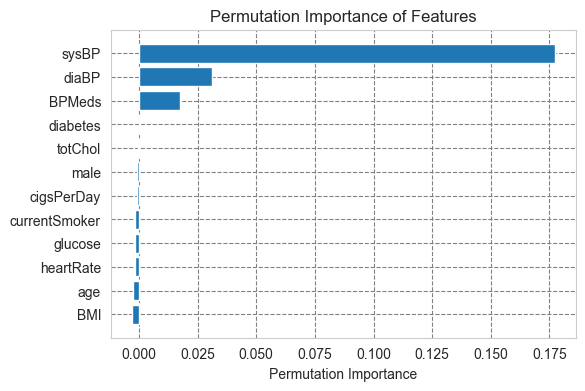

In [64]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(lr_best_clf, X_train_scaled, y_train, n_repeats=10, n_jobs=-1, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
feature_importances_lr = list(X_train.columns[sorted_idx])

plt.figure(figsize=(6, 4))
plt.barh(feature_importances_lr, perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

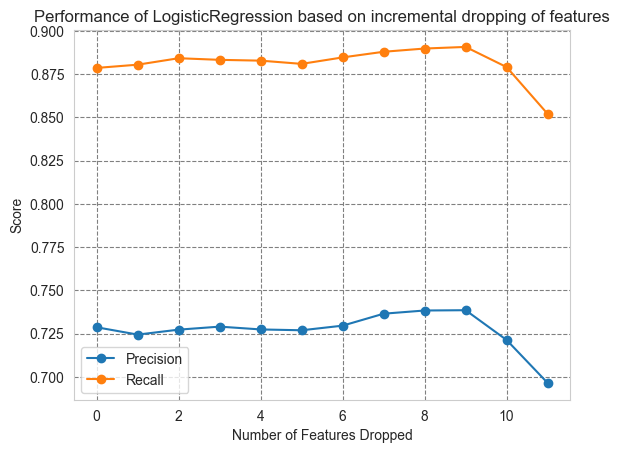

In [372]:
plot_performance_vs_features_dropped(feature_importances_lr, X_train, y_train, lr_best_clf)

***Remark***: The features dropping method used here has the same issue as mentioned before, but RFE cannot be used with this classifier. Ideally, we would need to use permutation importance after each feature drop to select the least important feature to drop next.

Cross-Validation Recall: 89.1 %
Cross-Validation Precision: 73.9 %

Cross Validation set size (in single fold): 875


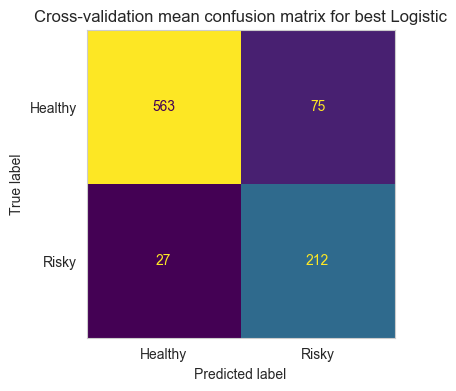

In [65]:
dropped_features = feature_importances_lr[:9]
X_train_lr = X_train.drop(dropped_features, axis=1)

fit_unscaled_and_cross_validate(X_train_lr, y_train, lr_best_clf);

print()

confusion_mat = avg_confusion_mat_cv(X_train_lr, y_train, lr_best_clf)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for best Logistic')

<center>

<span style="color:red">**Conclusion of feature selection**</span>

Slightly better performance was achieved thanks to feature selection using permutation importance. The retained features are **systolic, diastolic BP and BP medication** intake.

| **Model**         | Initial |   2  |   3  |                    Best                    |
|-------------------|:-------:|:----:|:----:|:------------------------------------------:|
| **Recall (%)**    | 75    | 93.8 |  87.9 | <span style="color:red">89.1</span>    |
| **Precision (%)** | 84.5     |  62.3 |  72.9| <span style="color:red">73.9</span>    |

</center>

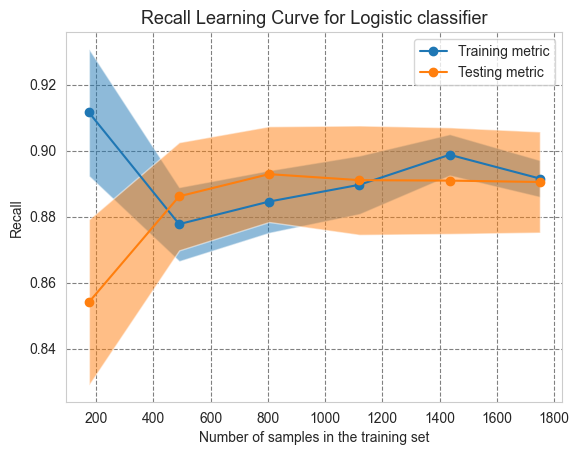

In [321]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(lr_best_clf, scale_data(X_train_lr), y_train, train_sizes=np.linspace(0.1, 1, 6), cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=42), scoring='recall',
                                    score_name='Recall', score_type='both', line_kw={"marker": "o"}, n_jobs=-1, random_state=42);

plt.title('Recall Learning Curve for Logistic classifier', fontsize=13);

It seems that acquiring more training data will not be useful as we reached a **plateau** on the validation recall score.

### **Voting classifier**

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(**lr_optimal_params, random_state=42, n_jobs=-1)
rnd_clf = RandomForestClassifier(**rf_optimal_params, n_jobs=-1, random_state=42)
svm_clf = SVC(**svc_optimal_params, random_state=42)
voting_basic = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard', n_jobs=-1)

# tailored_train_pairs = [(log_clf, X_train_lr), (rnd_clf, X_train_rf), (svm_clf, X_train_svc), (voting_basic, X_train_svc)]

for clf, train_data in [(voting_basic, X_train)]:
    print(f"[{clf.__class__.__name__}]")
    fit_unscaled_and_cross_validate(train_data, y_train, clf)

[VotingClassifier]
Cross-Validation Recall: 89.6 %
Cross-Validation Precision: 74.6 %


Cross Validation set size (in single fold): 875


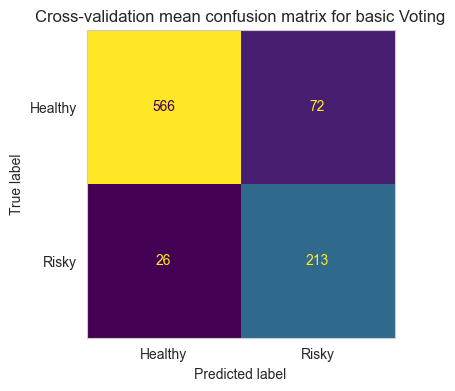

In [376]:
# Build the confusion matrix from cross validation scores
confusion_mat = avg_confusion_mat_cv(X_train, y_train, voting_basic)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for basic Voting')

#### **Hyperparameters optimization**

In [325]:
from sklearn.model_selection import GridSearchCV

param_dist = {
    'weights': [[1,1,1],[3,1,1],[1,3,1],[1,1,3],[3,3,1],[3,1,3],[1,3,3],[3,2,1],[3,1,2],[2,3,1],[1,3,2],[2,1,3],[1,2,3],[2,3,3],[3,3,2],[3,2,3],
                [4,1,1],[1,4,1],[1,1,4],[4,4,1],[4,1,4],[1,4,4],[4,2,1],[4,1,2],[2,4,1],[1,4,2],[2,1,4],[1,2,4],[2,4,4],[4,4,2],[4,2,4]]
}

random_search = GridSearchCV(estimator=voting_basic, param_grid=param_dist, cv=5, n_jobs=-1, verbose=2, scoring='recall')
random_search.fit(scale_data(X_train), y_train)

print(random_search.best_params_)

Fitting 5 folds for each of 31 candidates, totalling 155 fits
{'voting': 'hard', 'weights': [1, 3, 1]}


The Grid Search tells us to give **more preference to the Random Forest classifier** in the majority vote.

Cross-Validation Recall: 91.9 %
Cross-Validation Precision: 78.1 %

Cross Validation set size (in single fold): 875


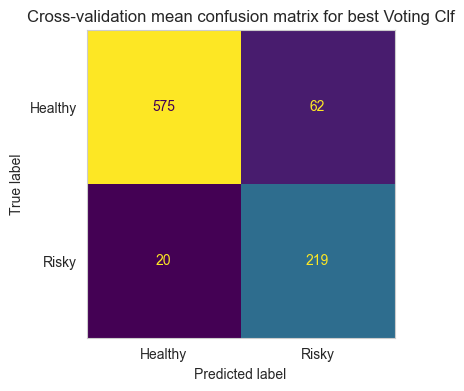

In [73]:
voting_optimal_params = {'weights': [1, 3, 1]}
voting_best_clf = VotingClassifier(**voting_optimal_params, estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard', n_jobs=-1)

fit_unscaled_and_cross_validate(X_train, y_train, voting_best_clf);

print()

confusion_mat = avg_confusion_mat_cv(X_train, y_train, voting_best_clf)
print("Cross Validation set size (in single fold):", X_train.shape[0] // MEAN_CONF_MAT_SPLITS)
plot_confusion_matrix(np.ceil(confusion_mat).astype(int), 'Cross-validation mean confusion matrix for best Voting Clf')

#### **Feature selection**

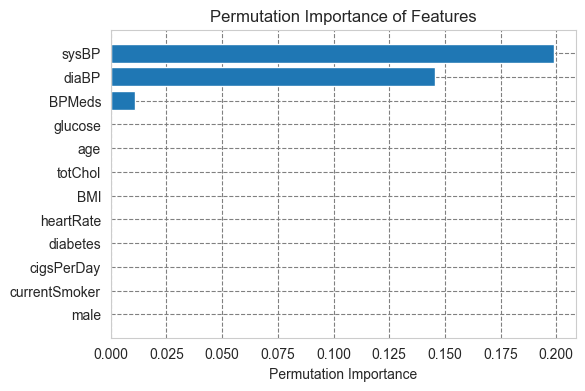

In [366]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(voting_best_clf, X_train_scaled, y_train, n_repeats=10, n_jobs=-1, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
feature_importances_voting = list(X_train.columns[sorted_idx])

plt.figure(figsize=(6, 4))
plt.barh(feature_importances_voting, perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

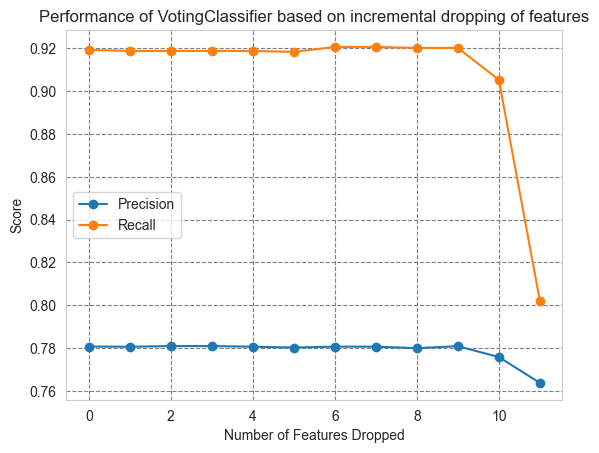

In [375]:
plot_performance_vs_features_dropped(feature_importances_voting, X_train, y_train, voting_best_clf)

Not dropping any feature is the same performance-wise as dropping from 1 to 9 features and keeping systolic, diastolic and BPMeds features.

***Remark***: The features dropping method used here has the same issue as mentioned before, but RFE cannot be used with this classifier. Ideally, we would need to use permutation importance after each feature drop to select the least important feature to drop next.

<center>

<span style="color:red">**Conclusion of feature selection**</span>

No significant improvement was made with feature selection through feature importances. The best validation performance remains **(92% R, 78.1% P)**\
There are 3 retained features: **systolic, diastolic BP, BP medication**.

</center>

<center>

| **Model**         | Initial |                    Best                    |
|-------------------|:-------:|:------------------------------------------:|
| **Recall (%)**    | 89.6    |   <span style="color:red">91.9</span>    |
| **Precision (%)** | 74.6     |   <span style="color:red">78.1</span>    |

</center>

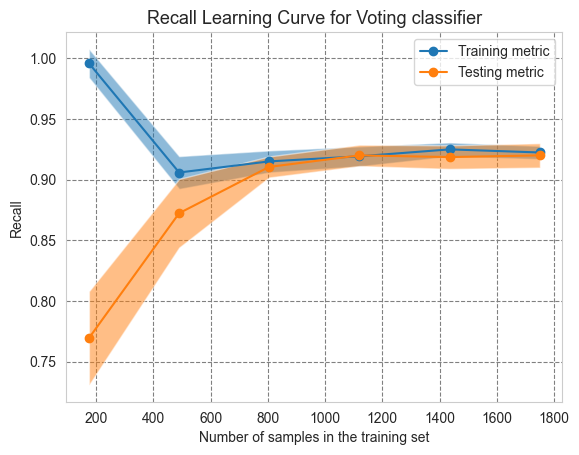

In [377]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(voting_best_clf, X_train_svc, y_train, train_sizes=np.linspace(0.1, 1, 6), cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=3, random_state=42), scoring='recall',
                                    score_name='Recall', score_type='both', line_kw={"marker": "o"}, n_jobs=-1, random_state=42);

plt.title('Recall Learning Curve for Voting classifier', fontsize=13);

It seems that acquiring more training data will not be useful as we reached a **plateau** on the validation recall score.

#### **Model selection**

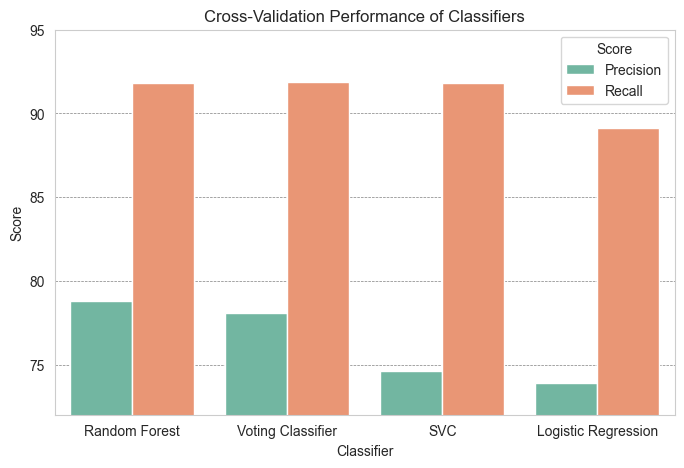

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

recall_rf = 91.8
precision_rf = 78.8
recall_svc = 91.8
precision_svc = 74.6
recall_lr = 89.1
precision_lr = 73.9
recall_voting = 91.9
precision_voting = 78.1

precision_scores = [precision_rf, precision_voting, precision_svc, precision_lr]
recall_scores = [recall_rf, recall_voting, recall_svc, recall_lr]

df_scores = pd.DataFrame({'Classifier': ['Random Forest', 'Voting Classifier', 'SVC', 'Logistic Regression', ],
                          'Precision': precision_scores,
                          'Recall': recall_scores})

# Melt the dataframe to create a long-form representation
df_melted = df_scores.melt(id_vars='Classifier', var_name='Score', value_name='Value')

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Classifier', y='Value', hue='Score', data=df_melted, palette='Set2')
ax.set_ylim(72, 95)
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5)

plt.title('Cross-Validation Performance of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.legend(title='Score')
plt.show()

The best performing classifier in cross-validation are **Random Forest** and **Voting Classifier**. Their performance are very similar. This is probably because the voting classifier gives preference to the Random Forest's decisions due to the weights that were used to configure it.

## Final model performance assessment

We will evaluate the **Random Forest** and **Voting** classifiers. Perhaps one of them will stand outm despite their similarities.

Random Forest Test Recall: 90.1%
Random Forest Test Precision: 72.6%
Random Forest Test F1 Score: 80.4%

(tn, fp, fn, tp), Test dataset size: 656


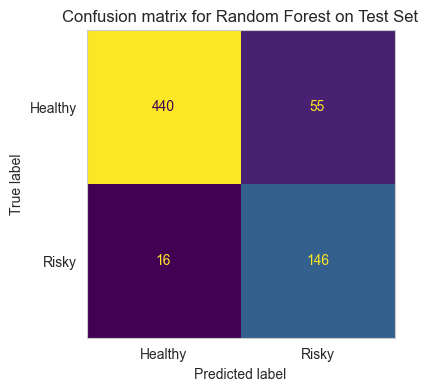

In [74]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

X_test_rf = X_test.loc[:, X_train_rf.columns]
X_test_rf_scaled = scale_data(X_train_rf, X_test_rf)[1]

y_pred_on_test = rf_best_clf.predict(X_test_rf_scaled)
confusion_mat = confusion_matrix(y_test, y_pred_on_test)

recall_rf_test = recall_score(y_test, y_pred_on_test)
precision_rf_test = precision_score(y_test, y_pred_on_test)
f1_rf_test = f1_score(y_test, y_pred_on_test)
print(bold_blue(f"Random Forest Test Recall: {recall_rf_test*100:.1f}%"))
print(bold_blue(f"Random Forest Test Precision: {precision_rf_test*100:.1f}%"))
print(bold_blue(f"Random Forest Test F1 Score: {f1_rf_test*100:.1f}%"))

print()

print(f"(tn, fp, fn, tp), Test dataset size: {int(TEST_SPLIT_PORTION * hypertension_data_cleaned.shape[0])}")
plot_confusion_matrix(confusion_mat, 'Confusion matrix for Random Forest on Test Set')

Random Forest Test Recall: 90.1%
Random Forest Test Precision: 72.6%
Random Forest Test F1 Score: 80.4%

(tn, fp, fn, tp), Test dataset size: 656


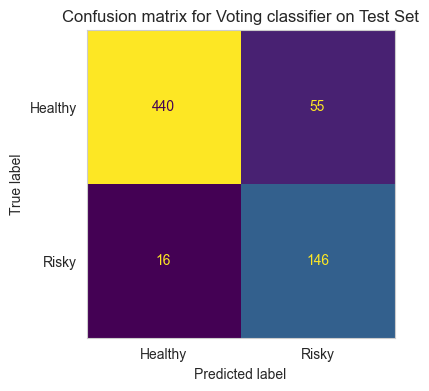

In [76]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

y_pred_on_test = voting_best_clf.predict(X_test_scaled)
confusion_mat = confusion_matrix(y_test, y_pred_on_test)

recall_voting_test = recall_score(y_test, y_pred_on_test)
precision_voting_test = precision_score(y_test, y_pred_on_test)
f1_voting_test = f1_score(y_test, y_pred_on_test)
print(bold_blue(f"Random Forest Test Recall: {recall_voting_test*100:.1f}%"))
print(bold_blue(f"Random Forest Test Precision: {precision_voting_test*100:.1f}%"))
print(bold_blue(f"Random Forest Test F1 Score: {f1_voting_test*100:.1f}%"))

print()

print(f"(tn, fp, fn, tp), Test dataset size: {int(TEST_SPLIT_PORTION * hypertension_data_cleaned.shape[0])}")
plot_confusion_matrix(confusion_mat, 'Confusion matrix for Voting classifier on Test Set')

It turns out both model perform as well on the test set. They have the same generalization capabilities. In terms of complexity, it would probably be better to choose the Random Forest as the Voting classifier contains other classifiers that do not seem to contribute enough to chose the Voting classifier over the RF.

**Limitations**

- I chose to stick mostly with RandomizedSearch : I might have missed optimal hyperparams, my params might only be quasi-optimal.

- Criticize default params like cv=5 (StratifiedKFold) ?

### Case conclusions

**Feature importance**

The most important features according to:
- Logistic Classifier are **systolic and diastolic BP, as well as BP medication**.
- Random Forest are 

**Identification of issues with the case (+mitigation measures)**